# Compas Data Imputation Analysis

In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from utils.data import create_compas_dataset, Dataset
from utils.generator import gen_complete_random
from utils.completer import complete_by_mean_col, complete_by_multi, complete_by_similar_row

In [4]:
data = create_compas_dataset()

In [5]:
data_compas_complete = data.copy()
tmp_concat = pd.concat([data_compas_complete.X, pd.DataFrame(data_compas_complete.y, columns=["_TARGET_"])], axis=1)
tmp_concat.dropna(inplace=True)
tmp_concat.reset_index(drop=True, inplace=True)
data_compas_complete.X = tmp_concat.drop(columns=["_TARGET_"]).copy()
data_compas_complete.y = tmp_concat["_TARGET_"].copy().to_numpy().ravel()

In [6]:
X = data_compas_complete.X.drop(columns=data_compas_complete.protected).copy().to_numpy()
y = data_compas_complete.y.copy()

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

In [8]:
from imblearn.over_sampling import SVMSMOTE

### Parameter Searching

In [9]:
from sklearn.model_selection import GridSearchCV

def grid_search(X, y, model, params, smote):
    print("Model: {}".format(model.__class__.__name__))
    X_res, y_res = smote.fit_resample(X, y) # enlarge dataset
    search = GridSearchCV(model, param_grid=params, cv=10, n_jobs=-1)
    search.fit(X_res, y_res)
    print("Best parameter: {}".format(search.best_params_))
    print("Acc best: {:.4f}".format(search.best_score_))
    print("Acc on input data: {:.4f}".format(search.best_estimator_.score(X, y)))
    print("Acc on enlarged data: {:.4f}".format(search.best_estimator_.score(X_res, y_res)))
    return search.best_params_

In [10]:
all_params = {
    "KNN": None,
    "LinearSVC": None,
    "SVC": None,
    "Forest": None,
    "LogReg": None,
    "Tree": None,
    "MLP": None,
}

In [11]:
tmp_params = {
    "n_neighbors": [2, 5, 10, 50, 100, 500],
    "leaf_size": [5, 10, 30, 50, 100],
}
all_params["KNN"] = grid_search(X, y, KNeighborsClassifier(), tmp_params, SVMSMOTE(random_state=22))

Model: KNeighborsClassifier
Best parameter: {'leaf_size': 5, 'n_neighbors': 2}
Acc best: 0.7061
Acc on input data: 0.8993
Acc on enlarged data: 0.9071


In [12]:
tmp_params = {
    "tol": [1e-5, 1e-4, 1e-3],
    "C": [0.001, 0.01, 0.1, 1, 10],
    "max_iter": [1000, 5000, 10000],
}
all_params["LinearSVC"] = grid_search(X, y, LinearSVC(dual=False), tmp_params, SVMSMOTE(random_state=22))

Model: LinearSVC
Best parameter: {'C': 0.1, 'max_iter': 1000, 'tol': 0.001}
Acc best: 0.6728
Acc on input data: 0.6641
Acc on enlarged data: 0.6725


In [13]:
tmp_params = {
    "tol": [1e-5, 1e-4, 1e-3],
    "C": [0.001, 0.01, 0.1, 1, 10],
    "max_iter": [1000, 5000, 10000, -1],
}
all_params["SVC"] = grid_search(X, y, SVC(), tmp_params, SVMSMOTE(random_state=22))

Model: SVC
Best parameter: {'C': 10, 'max_iter': -1, 'tol': 0.0001}
Acc best: 0.6452
Acc on input data: 0.6285
Acc on enlarged data: 0.6489


In [14]:
tmp_params = {
    "n_estimators": [50, 100, 200, 500],
    "max_depth": [None, 10, 50, 100],
    "min_samples_leaf": [1, 5, 10],
}
all_params["Forest"] = grid_search(X, y, RandomForestClassifier(), tmp_params, SVMSMOTE(random_state=22))

Model: RandomForestClassifier
Best parameter: {'max_depth': 50, 'min_samples_leaf': 5, 'n_estimators': 100}
Acc best: 0.7677
Acc on input data: 0.8166
Acc on enlarged data: 0.8567


In [15]:
tmp_params = {
    "tol": [1e-5, 1e-4, 1e-3],
    "C": [1e-2, 1e-1, 1, 1e1, 1e2],
    "max_iter": [100, 500, 1000, 2000],
}
all_params["LogReg"] = grid_search(X, y, LogisticRegression(), tmp_params, SVMSMOTE(random_state=22))

Model: LogisticRegression
Best parameter: {'C': 10.0, 'max_iter': 100, 'tol': 1e-05}
Acc best: 0.6755
Acc on input data: 0.6767
Acc on enlarged data: 0.6762


In [16]:
tmp_params = {
    "max_depth": [None, 10, 50, 100, 200],
    "max_leaf_nodes": [None, 10, 100, 1000],
    "min_samples_leaf": [1, 5, 10],
}
all_params["Tree"] = grid_search(X, y, DecisionTreeClassifier(), tmp_params, SVMSMOTE(random_state=22))

Model: DecisionTreeClassifier
Best parameter: {'max_depth': 10, 'max_leaf_nodes': 100, 'min_samples_leaf': 1}
Acc best: 0.7494
Acc on input data: 0.7267
Acc on enlarged data: 0.7765


In [17]:
tmp_params = {
    "alpha": [1e-5, 1e-4, 1e-3],
    "learning_rate_init": [1e-4, 1e-3, 1e-2],
    "max_iter": [200, 500, 1000],
}
all_params["MLP"] = grid_search(X, y, MLPClassifier(), tmp_params, SVMSMOTE(random_state=22))

Model: MLPClassifier
Best parameter: {'alpha': 0.0001, 'learning_rate_init': 0.01, 'max_iter': 500}
Acc best: 0.6878
Acc on input data: 0.6685
Acc on enlarged data: 0.6911


### Data Imputation

In [139]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

def bias1(data):
    # input should be data from compute_confusion_matrix: [tn, fp, fn, tp]
    # bias 1 = |(FPR_AA/FNR_AA) - (FPR_C/FNR_C)|
    FPR_AA = data["African-American"][1] / sum(data["African-American"])
    FNR_AA = data["African-American"][2] / sum(data["African-American"])
    FPR_C = data["Caucasian"][1] / sum(data["Caucasian"])
    FNR_C = data["Caucasian"][2] / sum(data["Caucasian"])
    bias = (FPR_AA / FNR_AA) - (FPR_C / FNR_C)
    return abs(bias)
   
def bias2(data):
    # input should be data from compute_confusion_matrix
    # bias 2 = |(FPR_AA/FPR_C) - (FNR_AA/FNR_C)|
    FPR_AA = data["African-American"][1] / sum(data["African-American"])
    FNR_AA = data["African-American"][2] / sum(data["African-American"])
    FPR_C = data["Caucasian"][1] / sum(data["Caucasian"])
    FNR_C = data["Caucasian"][2] / sum(data["Caucasian"])
    bias = (FPR_AA / FPR_C) - (FNR_AA / FNR_C)
    return abs(bias)

def helper_freq(array):
    """simple helper function to return the most frequent number in an array"""
    count = np.bincount(array)
    return array[np.argmax(count)]

def average_cv(cv_data):
    # compute average for the confusion matrix data for each fold
    result = {}
    for name, data in cv_data.items():
        new_data = {
            "African-American": np.array([m["African-American"] for m in data]).mean(axis=0).tolist(),
            "Caucasian": np.array([m["Caucasian"] for m in data]).mean(axis=0).tolist()
        }
        result[name] = new_data
    return result

def compute_confusion_matrix(X_train, y_train, X_test, y_test, clf, protected_features, multi=False):
    # X are pandas dataframe
    # y are numpy array
    # clf is a sklearn classifier
    # protected_features is list
    smote = SVMSMOTE(random_state=22)
    if not multi:
        X_train = X_train.drop(columns=protected_features).copy().to_numpy()
        X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
        clf.fit(X_train_res, y_train_res)
        print("Acc: {:.4f}".format(clf.score(X_test.drop(columns=protected_features).copy().to_numpy(), y_test)), end=" ")
        X_test_AA = X_test[X_test["race"] == "African-American"].drop(columns=protected_features).to_numpy()
        X_test_C = X_test[X_test["race"] == "Caucasian"].drop(columns=protected_features).to_numpy()
        y_test_AA = y_test[X_test[X_test["race"] == "African-American"].index.tolist()]
        y_test_C = y_test[X_test[X_test["race"] == "Caucasian"].index.tolist()]
        matrix_AA = confusion_matrix(y_test_AA, clf.predict(X_test_AA))
        matrix_C = confusion_matrix(y_test_C, clf.predict(X_test_C))
    else:
        prediction_AA = []
        prediction_C = []
        X_test_first = X_test[0]
        y_test_AA = y_test[X_test_first[X_test_first["race"] == "African-American"].index.tolist()]
        y_test_C = y_test[X_test_first[X_test_first["race"] == "Caucasian"].index.tolist()]
        scores = [0, 0]
        for X_train_m in X_train:
            X_train_m = X_train_m.drop(columns=protected_features).copy().to_numpy()
            X_train_res, y_train_res = smote.fit_resample(X_train_m, y_train)
            clf.fit(X_train_res, y_train_res)
            for X_test_m in X_test:
                X_test_AA = X_test_m[X_test_m["race"] == "African-American"].drop(columns=protected_features).to_numpy()
                X_test_C = X_test_m[X_test_m["race"] == "Caucasian"].drop(columns=protected_features).to_numpy()
                prediction_AA.append(clf.predict(X_test_AA))
                prediction_C.append(clf.predict(X_test_C))
                scores[0] += clf.score(X_test_m.drop(columns=protected_features).copy().to_numpy(), y_test)
                scores[1] += 1
        print("Acc: {:.4f}".format(scores[0] / scores[1]), end=" ")
        # compute final predictions by voting
        prediction_AA = np.apply_along_axis(helper_freq, 0, np.array(prediction_AA))
        prediction_C = np.apply_along_axis(helper_freq, 0, np.array(prediction_C))
        matrix_AA = confusion_matrix(y_test_AA, prediction_AA)
        matrix_C = confusion_matrix(y_test_C, prediction_C)
    result = {
        "African-American": matrix_AA.ravel().tolist(), # [tn, fp, fn, tp]
        "Caucasian": matrix_C.ravel().tolist()
    }
    return result

def test_imputation(X, y, protected_features, completer_func=None, multi=False):
    # X is pandas dataframe
    # y is numpy array,
    # protected_features is list
    # completer func is the imputation function
    global all_params
    clfs = { # define all the classifiers with best parameters
        "KNN": KNeighborsClassifier(n_neighbors=all_params["KNN"]["n_neighbors"], leaf_size=all_params["KNN"]["leaf_size"]),
        "LinearSVC": LinearSVC(dual=False, tol=all_params["LinearSVC"]["tol"], C=all_params["LinearSVC"]["C"], max_iter=all_params["LinearSVC"]["max_iter"]),
        "SVC": SVC(tol=all_params["SVC"]["tol"], C=all_params["SVC"]["C"], max_iter=all_params["SVC"]["max_iter"]),
        "Forest": RandomForestClassifier(n_estimators=all_params["Forest"]["n_estimators"], max_depth=all_params["Forest"]["max_depth"], min_samples_leaf=all_params["Forest"]["min_samples_leaf"]),
        "LogReg": LogisticRegression(tol=all_params["LogReg"]["tol"], C=all_params["LogReg"]["C"], max_iter=all_params["LogReg"]["max_iter"]),
        "Tree": DecisionTreeClassifier(max_depth=all_params["Tree"]["max_depth"], max_leaf_nodes=all_params["Tree"]["max_leaf_nodes"], min_samples_leaf=all_params["Tree"]["min_samples_leaf"]),
        "MLP": MLPClassifier(alpha=all_params["MLP"]["alpha"], learning_rate_init=all_params["MLP"]["learning_rate_init"], max_iter=all_params["MLP"]["max_iter"]),
    }
    data_cv = { # save each cv output
        "KNN": [],
        "LinearSVC": [],
        "SVC": [],
        "Forest": [],
        "LogReg": [],
        "Tree": [],
        "MLP": [],
    }
    bias1_cv = { # save each bias 1 outputs
        "KNN": [],
        "LinearSVC": [],
        "SVC": [],
        "Forest": [],
        "LogReg": [],
        "Tree": [],
        "MLP": [],
    }
    bias2_cv = { # save each bias 2 outputs
        "KNN": [],
        "LinearSVC": [],
        "SVC": [],
        "Forest": [],
        "LogReg": [],
        "Tree": [],
        "MLP": [],
    }
    kf = KFold(n_splits=10, shuffle=True)
    fold = 1
    for train_idx, test_idx in kf.split(X):
        print("Fold {:>2}".format(fold), end=" ")
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        X_test = X_test.reset_index(drop=True)
        X_train = X_train.reset_index(drop=True)
        if completer_func:
        # do imputations on training set and test set individually
            data_incomplete = Dataset("tmp", X_train, y_train, auto_convert=False, protected_features=protected_features)
            data_complete = completer_func(data_incomplete)
            X_train = [m.X.copy() for m in data_complete] if multi else data_complete.X.copy() 
            y_train = data_complete[0].y.copy() if multi else data_complete.y.copy()
            data_incomplete = Dataset("tmp", X_test, y_test, auto_convert=False, protected_features=protected_features)
            data_complete = completer_func(data_incomplete)
            X_test = [m.X.copy() for m in data_complete] if multi else data_complete.X.copy()
            y_test = data_complete[0].y.copy() if multi else data_complete.y.copy()
        # get result for each classifier
        for clf_name, clf in clfs.items():
            print("{}".format(clf_name), end=" ")
            result = compute_confusion_matrix(X_train, y_train, X_test, y_test, clf, protected_features, multi=multi)
            data_cv[clf_name].append(result)
            bias1_cv[clf_name].append(bias1(result))
            bias2_cv[clf_name].append(bias2(result))
        print()
        fold += 1
    # print("Result:\n{}".format(data_cv))
    return (data_cv, bias1_cv, bias2_cv)

In [140]:
# try on original data
result_original = test_imputation(data_compas_complete.X.copy(), data_compas_complete.y.copy(), data_compas_complete.protected)

Fold  1 KNN Acc: 0.6230 LinearSVC Acc: 0.6581 SVC Acc: 0.6124 Forest Acc: 0.6922 LogReg Acc: 0.6613 Tree Acc: 0.6880 MLP Acc: 0.6624 
Fold  2 KNN Acc: 0.6273 LinearSVC Acc: 0.6709 SVC Acc: 0.6049 Forest Acc: 0.7039 LogReg Acc: 0.6720 Tree Acc: 0.6933 MLP Acc: 0.6677 
Fold  3 KNN Acc: 0.6273 LinearSVC Acc: 0.6518 SVC Acc: 0.6081 Forest Acc: 0.7061 LogReg Acc: 0.6688 Tree Acc: 0.6912 MLP Acc: 0.6869 
Fold  4 KNN Acc: 0.6400 LinearSVC Acc: 0.6986 SVC Acc: 0.6049 Forest Acc: 0.7071 LogReg Acc: 0.6858 Tree Acc: 0.7039 MLP Acc: 0.6283 
Fold  5 KNN Acc: 0.6471 LinearSVC Acc: 0.6706 SVC Acc: 0.6162 Forest Acc: 0.6898 LogReg Acc: 0.6791 Tree Acc: 0.6823 MLP Acc: 0.6588 
Fold  6 KNN Acc: 0.6503 LinearSVC Acc: 0.6876 SVC Acc: 0.6205 Forest Acc: 0.7292 LogReg Acc: 0.6994 Tree Acc: 0.6908 MLP Acc: 0.5864 
Fold  7 KNN Acc: 0.6194 LinearSVC Acc: 0.6503 SVC Acc: 0.6386 Forest Acc: 0.6940 LogReg Acc: 0.6642 Tree Acc: 0.6716 MLP Acc: 0.6780 
Fold  8 KNN Acc: 0.6258 LinearSVC Acc: 0.6482 SVC Acc: 0.5842 

### 20% Random

In [141]:
# generate simulated missing data
data_sim = gen_complete_random(data_compas_complete, random_ratio=0.2)
data_sim.X.isnull().sum(axis=0)

gen_complete_random: 20980 NaN values have been inserted


age                        1694
age_cat                    1702
c_charge_degree            1749
priors_count               1759
juv_misd_count             1749
juv_fel_count              1780
juv_other_count            1720
c_charge_desc              1747
days_b_screening_arrest    1813
sex                        1799
race                       1724
length_of_stay             1744
dtype: int64

In [142]:
# fill by mean on simulated
result_mean_sim_20 = test_imputation(data_sim.X.copy(), data_sim.y.copy(), data_sim.protected, complete_by_mean_col)

Fold  1 KNN Acc: 0.6390 LinearSVC Acc: 0.6571 SVC Acc: 0.5591 Forest Acc: 0.5932 LogReg Acc: 0.6603 Tree Acc: 0.6006 MLP Acc: 0.6283 
Fold  2 KNN Acc: 0.6326 LinearSVC Acc: 0.6688 SVC Acc: 0.5964 Forest Acc: 0.6390 LogReg Acc: 0.6784 Tree Acc: 0.6592 MLP Acc: 0.6422 
Fold  3 KNN Acc: 0.6283 LinearSVC Acc: 0.6699 SVC Acc: 0.5911 Forest Acc: 0.5676 LogReg Acc: 0.6731 Tree Acc: 0.6049 MLP Acc: 0.5879 
Fold  4 KNN Acc: 0.5996 LinearSVC Acc: 0.6635 SVC Acc: 0.5719 Forest Acc: 0.6049 LogReg Acc: 0.6731 Tree Acc: 0.5868 MLP Acc: 0.6784 
Fold  5 KNN Acc: 0.6013 LinearSVC Acc: 0.6791 SVC Acc: 0.5533 Forest Acc: 0.5693 LogReg Acc: 0.6716 Tree Acc: 0.6109 MLP Acc: 0.5650 
Fold  6 KNN Acc: 0.5800 LinearSVC Acc: 0.6077 SVC Acc: 0.5448 Forest Acc: 0.5864 LogReg Acc: 0.6087 Tree Acc: 0.5874 MLP Acc: 0.6045 
Fold  7 KNN Acc: 0.5917 LinearSVC Acc: 0.6503 SVC Acc: 0.5554 Forest Acc: 0.5661 LogReg Acc: 0.6599 Tree Acc: 0.5959 MLP Acc: 0.5597 
Fold  8 KNN Acc: 0.6247 LinearSVC Acc: 0.6642 SVC Acc: 0.5800 

In [143]:
# fill by similar on simulated
result_similar_sim_20 = test_imputation(data_sim.X.copy(), data_sim.y.copy(), data_sim.protected, complete_by_similar_row)

Fold  1 KNN Acc: 0.6251 LinearSVC Acc: 0.6699 SVC Acc: 0.5740 Forest Acc: 0.6912 LogReg Acc: 0.6720 Tree Acc: 0.6773 MLP Acc: 0.5996 
Fold  2 KNN Acc: 0.6038 LinearSVC Acc: 0.6358 SVC Acc: 0.5804 Forest Acc: 0.6794 LogReg Acc: 0.6677 Tree Acc: 0.6539 MLP Acc: 0.5921 
Fold  3 KNN Acc: 0.6134 LinearSVC Acc: 0.6848 SVC Acc: 0.6113 Forest Acc: 0.6837 LogReg Acc: 0.6933 Tree Acc: 0.6805 MLP Acc: 0.6454 
Fold  4 KNN Acc: 0.6390 LinearSVC Acc: 0.6539 SVC Acc: 0.6177 Forest Acc: 0.6837 LogReg Acc: 0.6688 Tree Acc: 0.6528 MLP Acc: 0.6358 
Fold  5 KNN Acc: 0.6301 LinearSVC Acc: 0.6343 SVC Acc: 0.5725 Forest Acc: 0.6503 LogReg Acc: 0.6439 Tree Acc: 0.6141 MLP Acc: 0.6333 
Fold  6 KNN Acc: 0.6098 LinearSVC Acc: 0.6439 SVC Acc: 0.5853 Forest Acc: 0.6770 LogReg Acc: 0.6525 Tree Acc: 0.6514 MLP Acc: 0.6418 
Fold  7 KNN Acc: 0.6354 LinearSVC Acc: 0.6525 SVC Acc: 0.5757 Forest Acc: 0.6695 LogReg Acc: 0.6610 Tree Acc: 0.6514 MLP Acc: 0.6098 
Fold  8 KNN Acc: 0.6141 LinearSVC Acc: 0.6311 SVC Acc: 0.5853 

In [144]:
# fill by multiple imputation on simulated
result_multi_sim_20 = test_imputation(data_sim.X.copy(), data_sim.y.copy(), data_sim.protected, complete_by_multi, multi=True)

Fold  1 KNN Acc: 0.6111 LinearSVC Acc: 0.6156 SVC Acc: 0.5542 Forest Acc: 0.6285 LogReg Acc: 0.6245 Tree Acc: 0.6153 MLP Acc: 0.6073 
Fold  2 KNN Acc: 0.6168 LinearSVC Acc: 0.6675 SVC Acc: 0.5980 Forest Acc: 0.6844 LogReg Acc: 0.6712 Tree Acc: 0.6626 MLP Acc: 0.6631 
Fold  3 KNN Acc: 0.6345 LinearSVC Acc: 0.6489 SVC Acc: 0.6077 Forest Acc: 0.6667 LogReg Acc: 0.6561 Tree Acc: 0.6428 MLP Acc: 0.6388 
Fold  4 KNN Acc: 0.6219 LinearSVC Acc: 0.6382 SVC Acc: 0.5717 Forest Acc: 0.6434 LogReg Acc: 0.6399 Tree Acc: 0.6292 MLP Acc: 0.6274 
Fold  5 KNN Acc: 0.6216 LinearSVC Acc: 0.6489 SVC Acc: 0.5828 Forest Acc: 0.6803 LogReg Acc: 0.6599 Tree Acc: 0.6522 MLP Acc: 0.6136 
Fold  6 KNN Acc: 0.6238 LinearSVC Acc: 0.6286 SVC Acc: 0.5549 Forest Acc: 0.6676 LogReg Acc: 0.6360 Tree Acc: 0.6513 MLP Acc: 0.6163 
Fold  7 KNN Acc: 0.6209 LinearSVC Acc: 0.6471 SVC Acc: 0.5753 Forest Acc: 0.6460 LogReg Acc: 0.6453 Tree Acc: 0.6439 MLP Acc: 0.5942 
Fold  8 KNN Acc: 0.6016 LinearSVC Acc: 0.6474 SVC Acc: 0.5834 

### 10% Random

In [145]:
data_sim = gen_complete_random(data_compas_complete, random_ratio=0.1)
data_sim.X.isnull().sum(axis=0)

gen_complete_random: 8901 NaN values have been inserted


age                        738
age_cat                    728
c_charge_degree            769
priors_count               716
juv_misd_count             735
juv_fel_count              747
juv_other_count            759
c_charge_desc              761
days_b_screening_arrest    735
sex                        778
race                       741
length_of_stay             694
dtype: int64

In [146]:
# fill by mean on simulated
result_mean_sim_10 = test_imputation(data_sim.X.copy(), data_sim.y.copy(), data_sim.protected, complete_by_mean_col)

Fold  1 KNN Acc: 0.6060 LinearSVC Acc: 0.6560 SVC Acc: 0.6283 Forest Acc: 0.6773 LogReg Acc: 0.6592 Tree Acc: 0.6635 MLP Acc: 0.6550 
Fold  2 KNN Acc: 0.6262 LinearSVC Acc: 0.6741 SVC Acc: 0.6028 Forest Acc: 0.6592 LogReg Acc: 0.6581 Tree Acc: 0.6635 MLP Acc: 0.6092 
Fold  3 KNN Acc: 0.6305 LinearSVC Acc: 0.6720 SVC Acc: 0.6145 Forest Acc: 0.6507 LogReg Acc: 0.6741 Tree Acc: 0.6581 MLP Acc: 0.6454 
Fold  4 KNN Acc: 0.6283 LinearSVC Acc: 0.6645 SVC Acc: 0.5964 Forest Acc: 0.6667 LogReg Acc: 0.6731 Tree Acc: 0.6624 MLP Acc: 0.6432 
Fold  5 KNN Acc: 0.5885 LinearSVC Acc: 0.6557 SVC Acc: 0.5970 Forest Acc: 0.6429 LogReg Acc: 0.6588 Tree Acc: 0.6343 MLP Acc: 0.6130 
Fold  6 KNN Acc: 0.6322 LinearSVC Acc: 0.6525 SVC Acc: 0.6173 Forest Acc: 0.6461 LogReg Acc: 0.6642 Tree Acc: 0.6588 MLP Acc: 0.6418 
Fold  7 KNN Acc: 0.6567 LinearSVC Acc: 0.6439 SVC Acc: 0.6055 Forest Acc: 0.6695 LogReg Acc: 0.6578 Tree Acc: 0.6493 MLP Acc: 0.6439 
Fold  8 KNN Acc: 0.6482 LinearSVC Acc: 0.6759 SVC Acc: 0.6013 

In [147]:
# fill by similar on simulated
result_similar_sim_10 = test_imputation(data_sim.X.copy(), data_sim.y.copy(), data_sim.protected, complete_by_similar_row)

Fold  1 KNN Acc: 0.6251 LinearSVC Acc: 0.6305 SVC Acc: 0.5783 Forest Acc: 0.6837 LogReg Acc: 0.6443 Tree Acc: 0.6763 MLP Acc: 0.6656 
Fold  2 KNN Acc: 0.6251 LinearSVC Acc: 0.6539 SVC Acc: 0.6124 Forest Acc: 0.6635 LogReg Acc: 0.6688 Tree Acc: 0.6709 MLP Acc: 0.6709 
Fold  3 KNN Acc: 0.6518 LinearSVC Acc: 0.6305 SVC Acc: 0.6198 Forest Acc: 0.6709 LogReg Acc: 0.6518 Tree Acc: 0.6379 MLP Acc: 0.6560 
Fold  4 KNN Acc: 0.5996 LinearSVC Acc: 0.6581 SVC Acc: 0.5921 Forest Acc: 0.6699 LogReg Acc: 0.6613 Tree Acc: 0.6624 MLP Acc: 0.6454 
Fold  5 KNN Acc: 0.6535 LinearSVC Acc: 0.6642 SVC Acc: 0.5917 Forest Acc: 0.6908 LogReg Acc: 0.6834 Tree Acc: 0.6855 MLP Acc: 0.6461 
Fold  6 KNN Acc: 0.6119 LinearSVC Acc: 0.6375 SVC Acc: 0.6173 Forest Acc: 0.6780 LogReg Acc: 0.6450 Tree Acc: 0.6503 MLP Acc: 0.6802 
Fold  7 KNN Acc: 0.6365 LinearSVC Acc: 0.6610 SVC Acc: 0.6226 Forest Acc: 0.6748 LogReg Acc: 0.6748 Tree Acc: 0.6631 MLP Acc: 0.6365 
Fold  8 KNN Acc: 0.6311 LinearSVC Acc: 0.6780 SVC Acc: 0.6141 

In [148]:
# fill by multiple imputation on simulated
result_multi_sim_10 = test_imputation(data_sim.X.copy(), data_sim.y.copy(), data_sim.protected, complete_by_multi, multi=True)

Fold  1 KNN Acc: 0.6355 LinearSVC Acc: 0.6396 SVC Acc: 0.5878 Forest Acc: 0.6711 LogReg Acc: 0.6505 Tree Acc: 0.6569 MLP Acc: 0.6338 
Fold  2 KNN Acc: 0.6220 LinearSVC Acc: 0.6474 SVC Acc: 0.5669 Forest Acc: 0.6449 LogReg Acc: 0.6542 Tree Acc: 0.6561 MLP Acc: 0.6339 
Fold  3 KNN Acc: 0.6219 LinearSVC Acc: 0.6573 SVC Acc: 0.5921 Forest Acc: 0.6941 LogReg Acc: 0.6676 Tree Acc: 0.6779 MLP Acc: 0.6524 
Fold  4 KNN Acc: 0.6265 LinearSVC Acc: 0.6741 SVC Acc: 0.5824 Forest Acc: 0.6831 LogReg Acc: 0.6780 Tree Acc: 0.6703 MLP Acc: 0.6724 
Fold  5 KNN Acc: 0.6217 LinearSVC Acc: 0.6325 SVC Acc: 0.5931 Forest Acc: 0.6621 LogReg Acc: 0.6390 Tree Acc: 0.6511 MLP Acc: 0.6388 
Fold  6 KNN Acc: 0.6410 LinearSVC Acc: 0.6855 SVC Acc: 0.6248 Forest Acc: 0.6785 LogReg Acc: 0.6820 Tree Acc: 0.6591 MLP Acc: 0.6781 
Fold  7 KNN Acc: 0.6301 LinearSVC Acc: 0.6309 SVC Acc: 0.5666 Forest Acc: 0.6571 LogReg Acc: 0.6417 Tree Acc: 0.6560 MLP Acc: 0.6148 
Fold  8 KNN Acc: 0.6264 LinearSVC Acc: 0.6873 SVC Acc: 0.5939 

### 5% Random

In [149]:
data_sim = gen_complete_random(data_compas_complete, random_ratio=0.05)
data_sim.X.isnull().sum(axis=0)

gen_complete_random: 4196 NaN values have been inserted


age                        355
age_cat                    337
c_charge_degree            358
priors_count               348
juv_misd_count             317
juv_fel_count              347
juv_other_count            368
c_charge_desc              374
days_b_screening_arrest    362
sex                        344
race                       333
length_of_stay             353
dtype: int64

In [150]:
# fill by mean on simulated
result_mean_sim_5 = test_imputation(data_sim.X.copy(), data_sim.y.copy(), data_sim.protected, complete_by_mean_col)

Fold  1 KNN Acc: 0.6315 LinearSVC Acc: 0.6645 SVC Acc: 0.5996 Forest Acc: 0.6805 LogReg Acc: 0.6752 Tree Acc: 0.6592 MLP Acc: 0.6337 
Fold  2 KNN Acc: 0.6432 LinearSVC Acc: 0.6645 SVC Acc: 0.6209 Forest Acc: 0.6763 LogReg Acc: 0.6624 Tree Acc: 0.6624 MLP Acc: 0.6581 
Fold  3 KNN Acc: 0.6603 LinearSVC Acc: 0.6954 SVC Acc: 0.6294 Forest Acc: 0.7039 LogReg Acc: 0.7018 Tree Acc: 0.7029 MLP Acc: 0.6379 
Fold  4 KNN Acc: 0.6145 LinearSVC Acc: 0.6581 SVC Acc: 0.6102 Forest Acc: 0.6773 LogReg Acc: 0.6560 Tree Acc: 0.6741 MLP Acc: 0.6422 
Fold  5 KNN Acc: 0.6333 LinearSVC Acc: 0.6375 SVC Acc: 0.6055 Forest Acc: 0.6855 LogReg Acc: 0.6482 Tree Acc: 0.6919 MLP Acc: 0.6610 
Fold  6 KNN Acc: 0.6109 LinearSVC Acc: 0.6365 SVC Acc: 0.6141 Forest Acc: 0.6482 LogReg Acc: 0.6461 Tree Acc: 0.6567 MLP Acc: 0.6269 
Fold  7 KNN Acc: 0.6397 LinearSVC Acc: 0.6471 SVC Acc: 0.5928 Forest Acc: 0.6812 LogReg Acc: 0.6652 Tree Acc: 0.6599 MLP Acc: 0.6493 
Fold  8 KNN Acc: 0.6279 LinearSVC Acc: 0.6663 SVC Acc: 0.6034 

In [151]:
# fill by similar on simulated
result_similar_sim_5 = test_imputation(data_sim.X.copy(), data_sim.y.copy(), data_sim.protected, complete_by_similar_row)

Fold  1 KNN Acc: 0.6198 LinearSVC Acc: 0.6645 SVC Acc: 0.5879 Forest Acc: 0.7146 LogReg Acc: 0.6496 Tree Acc: 0.6837 MLP Acc: 0.6677 
Fold  2 KNN Acc: 0.6145 LinearSVC Acc: 0.6667 SVC Acc: 0.5942 Forest Acc: 0.6869 LogReg Acc: 0.6816 Tree Acc: 0.6826 MLP Acc: 0.6752 
Fold  3 KNN Acc: 0.6251 LinearSVC Acc: 0.6613 SVC Acc: 0.6283 Forest Acc: 0.6784 LogReg Acc: 0.6752 Tree Acc: 0.6826 MLP Acc: 0.6262 
Fold  4 KNN Acc: 0.6475 LinearSVC Acc: 0.6645 SVC Acc: 0.6028 Forest Acc: 0.6922 LogReg Acc: 0.6805 Tree Acc: 0.6869 MLP Acc: 0.6305 
Fold  5 KNN Acc: 0.6247 LinearSVC Acc: 0.6610 SVC Acc: 0.5981 Forest Acc: 0.6748 LogReg Acc: 0.6652 Tree Acc: 0.6706 MLP Acc: 0.6301 
Fold  6 KNN Acc: 0.6493 LinearSVC Acc: 0.6759 SVC Acc: 0.6354 Forest Acc: 0.6876 LogReg Acc: 0.6748 Tree Acc: 0.6823 MLP Acc: 0.6631 
Fold  7 KNN Acc: 0.6386 LinearSVC Acc: 0.6493 SVC Acc: 0.6119 Forest Acc: 0.6791 LogReg Acc: 0.6631 Tree Acc: 0.6695 MLP Acc: 0.6578 
Fold  8 KNN Acc: 0.6173 LinearSVC Acc: 0.6333 SVC Acc: 0.6269 

In [152]:
# fill by multiple imputation on simulated
result_multi_sim_5 = test_imputation(data_sim.X.copy(), data_sim.y.copy(), data_sim.protected, complete_by_multi, multi=True)

Fold  1 KNN Acc: 0.6450 LinearSVC Acc: 0.6736 SVC Acc: 0.6017 Forest Acc: 0.7083 LogReg Acc: 0.6853 Tree Acc: 0.6732 MLP Acc: 0.6615 
Fold  2 KNN Acc: 0.6307 LinearSVC Acc: 0.6790 SVC Acc: 0.5890 Forest Acc: 0.7070 LogReg Acc: 0.6856 Tree Acc: 0.6862 MLP Acc: 0.6744 
Fold  3 KNN Acc: 0.6375 LinearSVC Acc: 0.6262 SVC Acc: 0.5885 Forest Acc: 0.6735 LogReg Acc: 0.6300 Tree Acc: 0.6586 MLP Acc: 0.6562 
Fold  4 KNN Acc: 0.6484 LinearSVC Acc: 0.6829 SVC Acc: 0.6265 Forest Acc: 0.7134 LogReg Acc: 0.6939 Tree Acc: 0.7051 MLP Acc: 0.6675 
Fold  5 KNN Acc: 0.6414 LinearSVC Acc: 0.6424 SVC Acc: 0.6101 Forest Acc: 0.6797 LogReg Acc: 0.6501 Tree Acc: 0.6755 MLP Acc: 0.6235 
Fold  6 KNN Acc: 0.6252 LinearSVC Acc: 0.6423 SVC Acc: 0.5563 Forest Acc: 0.6729 LogReg Acc: 0.6520 Tree Acc: 0.6565 MLP Acc: 0.6248 
Fold  7 KNN Acc: 0.6108 LinearSVC Acc: 0.6564 SVC Acc: 0.6071 Forest Acc: 0.6762 LogReg Acc: 0.6624 Tree Acc: 0.6638 MLP Acc: 0.6432 
Fold  8 KNN Acc: 0.6419 LinearSVC Acc: 0.6741 SVC Acc: 0.5819 

### Save Results

In [153]:
# save confusion matrix for each classifier
classifiers = ["KNN", "LinearSVC", "SVC", "Forest", "LogReg", "Tree", "MLP"]
raw_data = [result_original, result_mean_sim_20, result_similar_sim_20, result_multi_sim_20,
            result_mean_sim_10, result_similar_sim_10, result_multi_sim_10,
            result_mean_sim_5, result_similar_sim_5, result_multi_sim_5]
fold_names = ["(Fold {:>2})".format(x+1) for x in range(10)]
conf_names = [x + " " + y for y in fold_names
              for x in ["TN_AA", "FP_AA", "FN_AA", "TP_AA", "TN_C", "FP_C", "FN_C", "TP_C"]]
methods = ["Original",
           "Mean Imputation (20%)",
           "Similar Imputation (20%)",
           "Multiple Imputation (20%)",
           "Mean Imputation (10%)",
           "Similar Imputation (10%)",
           "Multiple Imputation (10%)",
           "Mean Imputation (5%)",
           "Similar Imputation (5%)",
           "Multiple Imputation (5%)"]

if not os.path.exists("compas_analysis"):
    os.makedirs("compas_analysis")

for clf_name in classifiers:
    if not os.path.exists(os.path.join("compas_analysis", clf_name)):
        os.makedirs(os.path.join("compas_analysis", clf_name))    

In [154]:
def save_cv(data):
    data_cv = [m[0] for m in data]
    for clf_name in classifiers:
        new_data = []
        new_data_acc = []
        dd = [m[clf_name] for m in data_cv]
        for fold_10 in dd:
            fold_line = []
            fold_line_acc = []
            for fold in fold_10:
                fold_line += fold["African-American"]
                fold_line += fold["Caucasian"]
                fold_line_acc.append(
                    (fold["African-American"][0] + fold["African-American"][3] +
                     fold["Caucasian"][0] + fold["Caucasian"][3]) /
                    (sum(fold["African-American"]) + sum(fold["Caucasian"]))
                )
            new_data.append(fold_line)
            fold_line_acc.append(sum(fold_line_acc) / len(fold_line_acc))
            new_data_acc.append(fold_line_acc)
        df = pd.DataFrame(new_data, columns=conf_names, index=methods)
        df.transpose().to_csv(os.path.join("compas_analysis", clf_name, "10folds.csv"))
        df = pd.DataFrame(new_data_acc, columns=fold_names + ["Average"], index=methods)
        df.transpose().to_csv(os.path.join("compas_analysis", clf_name, "accuracy.csv"))

In [155]:
def save_bias(data):
    bias1 = [m[1] for m in data]
    bias2 = [m[2] for m in data]
    for clf_name in classifiers:
        bias1_clf = [m[clf_name] for m in bias1]
        bias1_clf = [x + [sum(x) / len(x)] for x in bias1_clf]
        bias2_clf = [m[clf_name] for m in bias2]
        bias2_clf = [x + [sum(x) / len(x)] for x in bias2_clf]
        df1 = pd.DataFrame(bias1_clf, columns=fold_names + ["Average"], index=methods)
        df2 = pd.DataFrame(bias2_clf, columns=fold_names + ["Average"], index=methods)
        df1.transpose().to_csv(os.path.join("compas_analysis", clf_name, "bias1.csv"))
        df2.transpose().to_csv(os.path.join("compas_analysis", clf_name, "bias2.csv"))

In [156]:
save_cv(raw_data)
save_bias(raw_data)

### Plots

In [157]:
import matplotlib.pyplot as plt
import seaborn as sns

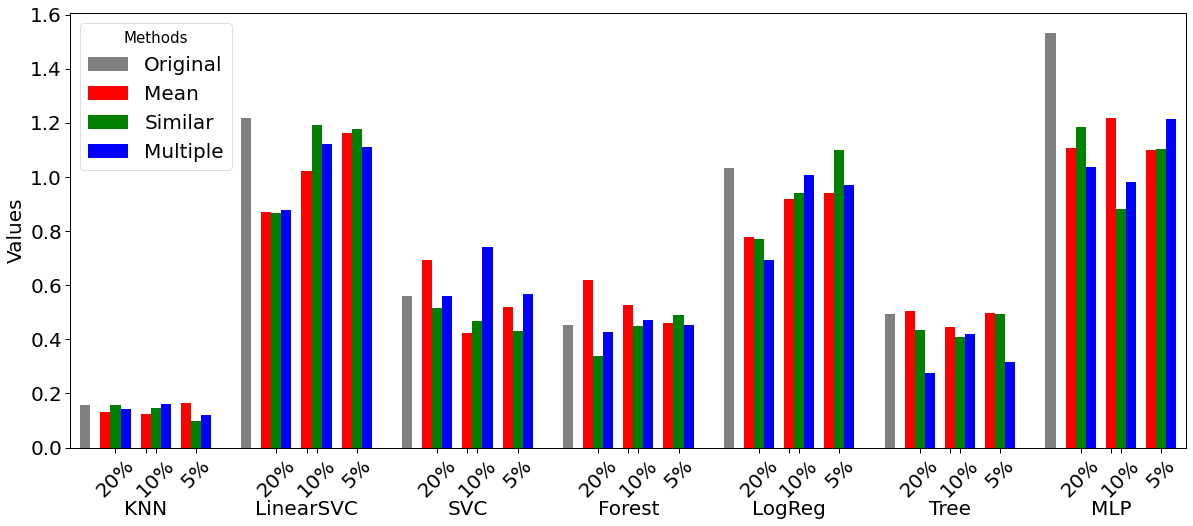

In [184]:
fig = plt.figure(figsize=(20, 8))
fig.patch.set_alpha(1.0)
ax = fig.add_subplot(111)
ax.tick_params(labelsize=20)
# plt.title("Compas Analysis: Bias 1", fontsize=20)
plot_basic_pos = np.arange(len(classifiers)) * 16
plot_additional_pos = [0, 2, 3, 4, 6, 7, 8, 10, 11, 12]
plot_xticks_pos = np.array([np.array([3.5, 6.5, 7.5, 11.5]) + m for m in plot_basic_pos]).ravel().tolist()
plot_xtick_labels = np.array([["20%", "\n\n{}".format(name), "10%", "5%"] for name in classifiers]).ravel().tolist()
plot_data = []
for clf_name in classifiers:
    dd = pd.read_csv(os.path.join("compas_analysis", clf_name, "bias1.csv"), index_col=0)
    avg = dd.loc["Average"].tolist()
    plot_data.append(avg)
plot_data = np.array(plot_data).T
plot_methods = ["Original", "Mean", "Similar", "Multiple"]
plot_barcolors = ["grey", "red", "green", "blue",
                  "red", "green", "blue",
                  "red", "green", "blue"]
for (i, method) in enumerate(methods):
    ax.bar(plot_basic_pos + plot_additional_pos[i] + 0.5, plot_data[i], 1, label=plot_methods[i] if i < 4 else None, color=plot_barcolors[i])
plt.xticks(plot_xticks_pos)
ax.set_xticklabels(plot_xtick_labels)
for label in ax.get_xmajorticklabels():
    if "%" in label.get_text():
        label.set_rotation(45)
        label.set_horizontalalignment("center")
plt.ylabel("Values", fontsize=20)
plt.xlim([-1, 16*len(classifiers) - 2])
plt.legend(title="Methods", loc="upper left", prop={"size": 20}, title_fontsize=15)
plt.savefig("bias1.png", transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

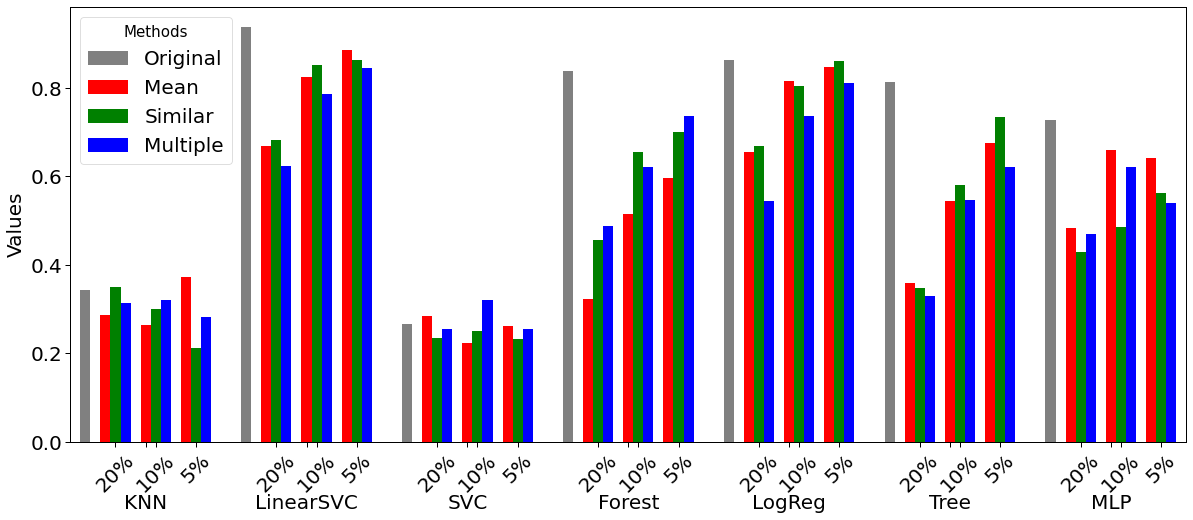

In [185]:
fig = plt.figure(figsize=(20, 8))
fig.patch.set_alpha(1.0)
ax = fig.add_subplot(111)
ax.tick_params(labelsize=20)
# plt.title("Compas Analysis: Bias 2", fontsize=20)
plot_basic_pos = np.arange(len(classifiers)) * 16
plot_additional_pos = [0, 2, 3, 4, 6, 7, 8, 10, 11, 12]
plot_xticks_pos = np.array([np.array([3.5, 6.5, 7.5, 11.5]) + m for m in plot_basic_pos]).ravel().tolist()
plot_xtick_labels = np.array([["20%", "\n\n{}".format(name), "10%", "5%"] for name in classifiers]).ravel().tolist()
plot_data = []
for clf_name in classifiers:
    dd = pd.read_csv(os.path.join("compas_analysis", clf_name, "bias2.csv"), index_col=0)
    avg = dd.loc["Average"].tolist()
    plot_data.append(avg)
plot_data = np.array(plot_data).T
plot_methods = ["Original", "Mean", "Similar", "Multiple"]
plot_barcolors = ["grey", "red", "green", "blue",
                  "red", "green", "blue",
                  "red", "green", "blue"]
for (i, method) in enumerate(methods):
    ax.bar(plot_basic_pos + plot_additional_pos[i] + 0.5, plot_data[i], 1, label=plot_methods[i] if i < 4 else None, color=plot_barcolors[i])
plt.xticks(plot_xticks_pos)
ax.set_xticklabels(plot_xtick_labels)
for label in ax.get_xmajorticklabels():
    if "%" in label.get_text():
        label.set_rotation(45)
        label.set_horizontalalignment("center")
plt.ylabel("Values", fontsize=20)
plt.xlim([-1, 16*len(classifiers) - 2])
plt.legend(title="Methods", loc="upper left", prop={"size": 20}, title_fontsize=15)
plt.savefig("bias2.png", transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

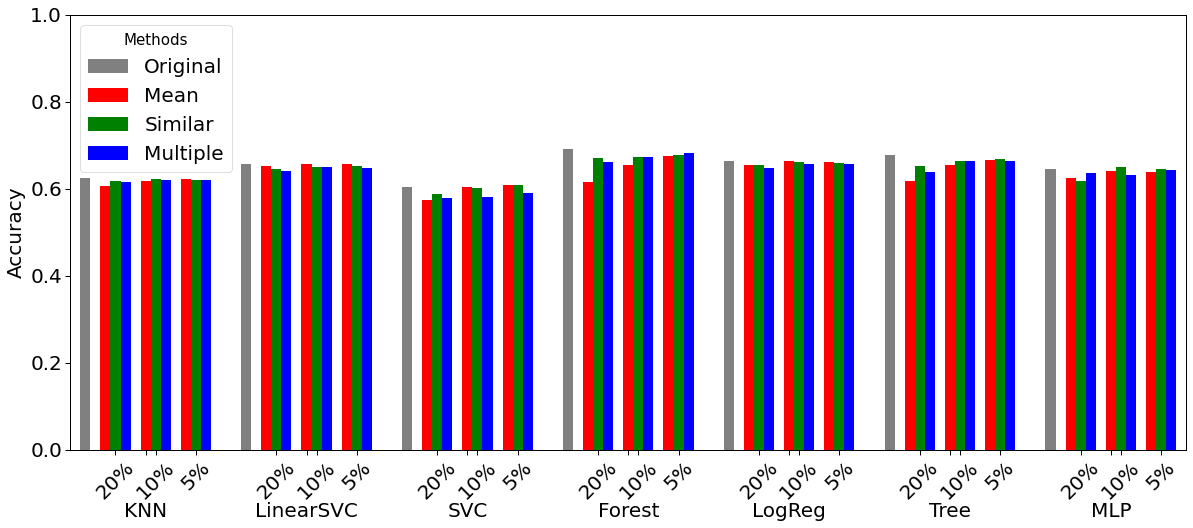

In [186]:
fig = plt.figure(figsize=(20, 8))
fig.patch.set_alpha(1.0)
ax = fig.add_subplot(111)
ax.tick_params(labelsize=20)
# plt.title("Compas Analysis: Accuracy", fontsize=20)
plot_basic_pos = np.arange(len(classifiers)) * 16
plot_additional_pos = [0, 2, 3, 4, 6, 7, 8, 10, 11, 12]
plot_xticks_pos = np.array([np.array([3.5, 6.5, 7.5, 11.5]) + m for m in plot_basic_pos]).ravel().tolist()
plot_xtick_labels = np.array([["20%", "\n\n{}".format(name), "10%", "5%"] for name in classifiers]).ravel().tolist()
plot_data = []
for clf_name in classifiers:
    dd = pd.read_csv(os.path.join("compas_analysis", clf_name, "accuracy.csv"), index_col=0)
    avg = dd.loc["Average"].tolist()
    plot_data.append(avg)
plot_data = np.array(plot_data).T
plot_methods = ["Original", "Mean", "Similar", "Multiple"]
plot_barcolors = ["grey", "red", "green", "blue",
                  "red", "green", "blue",
                  "red", "green", "blue"]
for (i, method) in enumerate(methods):
    ax.bar(plot_basic_pos + plot_additional_pos[i] + 0.5, plot_data[i], 1, label=plot_methods[i] if i < 4 else None, color=plot_barcolors[i])
plt.xticks(plot_xticks_pos)
ax.set_xticklabels(plot_xtick_labels)
for label in ax.get_xmajorticklabels():
    if "%" in label.get_text():
        label.set_rotation(45)
        label.set_horizontalalignment("center")
plt.ylabel("Accuracy", fontsize=20)
plt.xlim([-1, 16*len(classifiers) - 2])
plt.ylim([0.0, 1.0])
plt.legend(title="Methods", loc="upper left", prop={"size": 20}, title_fontsize=15)
plt.savefig("accuracy.png", transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

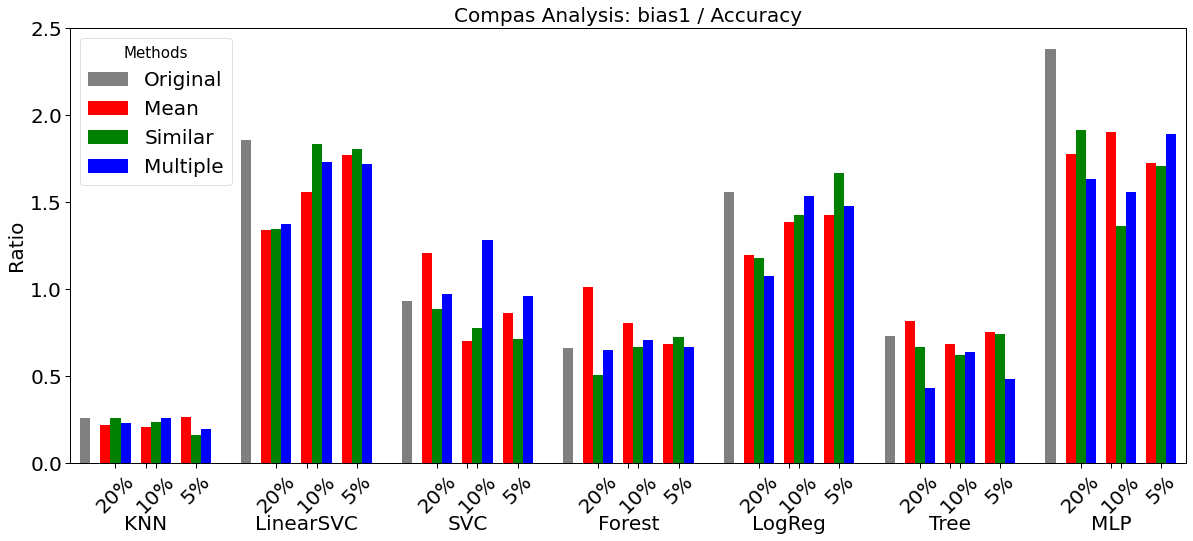

In [191]:
fig = plt.figure(figsize=(20, 8))
fig.patch.set_alpha(1.0)
ax = fig.add_subplot(111)
ax.tick_params(labelsize=20)
plt.title("Compas Analysis: bias1 / Accuracy", fontsize=20)
plot_basic_pos = np.arange(len(classifiers)) * 16
plot_additional_pos = [0, 2, 3, 4, 6, 7, 8, 10, 11, 12]
plot_xticks_pos = np.array([np.array([3.5, 6.5, 7.5, 11.5]) + m for m in plot_basic_pos]).ravel().tolist()
plot_xtick_labels = np.array([["20%", "\n\n{}".format(name), "10%", "5%"] for name in classifiers]).ravel().tolist()
plot_data = []
for clf_name in classifiers:
    dd1 = pd.read_csv(os.path.join("compas_analysis", clf_name, "accuracy.csv"), index_col=0)
    avg1 = np.array(dd1.loc["Average"].tolist())
    dd2 = pd.read_csv(os.path.join("compas_analysis", clf_name, "bias1.csv"), index_col=0)
    avg2 = np.array(dd2.loc["Average"].tolist())
    avg = avg2 / avg1
    plot_data.append(avg.tolist())
plot_data = np.array(plot_data).T
plot_methods = ["Original", "Mean", "Similar", "Multiple"]
plot_barcolors = ["grey", "red", "green", "blue",
                  "red", "green", "blue",
                  "red", "green", "blue"]
for (i, method) in enumerate(methods):
    ax.bar(plot_basic_pos + plot_additional_pos[i] + 0.5, plot_data[i], 1, label=plot_methods[i] if i < 4 else None, color=plot_barcolors[i])
plt.xticks(plot_xticks_pos)
ax.set_xticklabels(plot_xtick_labels)
for label in ax.get_xmajorticklabels():
    if "%" in label.get_text():
        label.set_rotation(45)
        label.set_horizontalalignment("center")
plt.ylabel("Ratio", fontsize=20)
plt.xlim([-1, 16*len(classifiers) - 2])
plt.ylim([0.0, 2.5])
plt.legend(title="Methods", loc="upper left", prop={"size": 20}, title_fontsize=15)
plt.savefig("ratio1.png", transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()

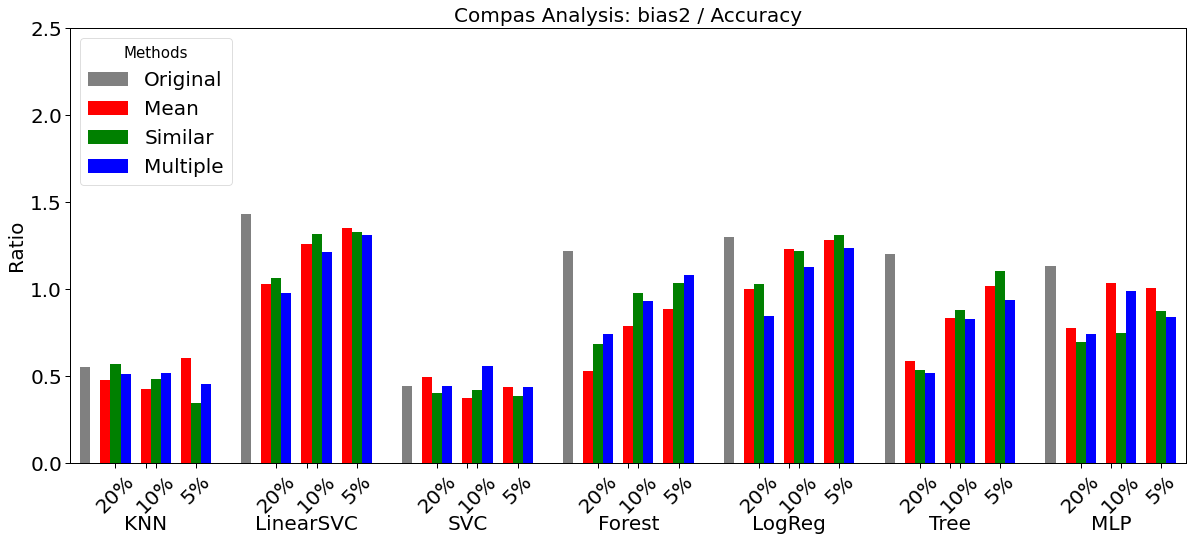

In [192]:
fig = plt.figure(figsize=(20, 8))
fig.patch.set_alpha(1.0)
ax = fig.add_subplot(111)
ax.tick_params(labelsize=20)
plt.title("Compas Analysis: bias2 / Accuracy", fontsize=20)
plot_basic_pos = np.arange(len(classifiers)) * 16
plot_additional_pos = [0, 2, 3, 4, 6, 7, 8, 10, 11, 12]
plot_xticks_pos = np.array([np.array([3.5, 6.5, 7.5, 11.5]) + m for m in plot_basic_pos]).ravel().tolist()
plot_xtick_labels = np.array([["20%", "\n\n{}".format(name), "10%", "5%"] for name in classifiers]).ravel().tolist()
plot_data = []
for clf_name in classifiers:
    dd1 = pd.read_csv(os.path.join("compas_analysis", clf_name, "accuracy.csv"), index_col=0)
    avg1 = np.array(dd1.loc["Average"].tolist())
    dd2 = pd.read_csv(os.path.join("compas_analysis", clf_name, "bias2.csv"), index_col=0)
    avg2 = np.array(dd2.loc["Average"].tolist())
    avg = avg2 / avg1
    plot_data.append(avg.tolist())
plot_data = np.array(plot_data).T
plot_methods = ["Original", "Mean", "Similar", "Multiple"]
plot_barcolors = ["grey", "red", "green", "blue",
                  "red", "green", "blue",
                  "red", "green", "blue"]
for (i, method) in enumerate(methods):
    ax.bar(plot_basic_pos + plot_additional_pos[i] + 0.5, plot_data[i], 1, label=plot_methods[i] if i < 4 else None, color=plot_barcolors[i])
plt.xticks(plot_xticks_pos)
ax.set_xticklabels(plot_xtick_labels)
for label in ax.get_xmajorticklabels():
    if "%" in label.get_text():
        label.set_rotation(45)
        label.set_horizontalalignment("center")
plt.ylabel("Ratio", fontsize=20)
plt.xlim([-1, 16*len(classifiers) - 2])
plt.ylim([0.0, 2.5])
plt.legend(title="Methods", loc="upper left", prop={"size": 20}, title_fontsize=15)
plt.savefig("ratio2.png", transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()